<a href="https://colab.research.google.com/github/mocialov/GTL/blob/master/TPS_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install opencv-contrib-python
!pip install scikit-image

In [0]:
with open('content/backgrounds.txt','w') as backgrounds:
    backgrounds.write('''https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/living-room-9-1537479929.jpg''')

with open('content/puma.txt','w') as brands:
    brands.write('''https://kickz.akamaized.net/en/media/images/p/1200/puma-Archive_Logo_T_Shirt-Puma_White-1.jpg''')

#Imports

In [0]:
%matplotlib inline
%pylab inline

import cv2
import numpy as np
import random
from PIL import Image
from argparse import ArgumentParser
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
import uuid
import cv2
from matplotlib import pyplot as plt
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

#Globals

In [0]:
background_resized_height = 1152
top_resized_height = int(background_resized_height * 0.5)
augmentation_resize_factor = 0.5
spline_size = (5,5)
bounding_box_padding = int(top_resized_height*0.2)

#Augment

In [53]:
def get_image_top(url):
    return io.imread(url)

def get_background_image(url):
    return io.imread(url)

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized


def get_spline_matrix(size=(5,5)):
	nx, ny = size
	x = np.linspace(0, 1, nx)
	y = np.linspace(0, 1, ny)
	xv, yv = np.meshgrid(x, y)

	return list(zip(xv.flatten(), yv.flatten()))


def overlay_transparent(background, overlay, x=0, y=0):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

def adjust_hsv(img, hue, saturation, brightness):
	hsvImg = cv2.cvtColor(np.float32(img),cv2.COLOR_BGR2HSV)

	#hsvImg[...,0] = hsvImg[...,0] * hue

	#multiple by a factor to change the saturation
	hsvImg[...,1] = hsvImg[...,1] * saturation

	#multiple by a factor of less than 1 to reduce the brightness 
	hsvImg[...,2] = hsvImg[...,2] * brightness

	img = cv2.cvtColor(hsvImg,cv2.COLOR_HSV2BGR)

	return img


def augment(background_url, top_url, top_id, background_id, generated_version, warping_factor, saturation, brightness, hue, brand, rotation_angle):

	im = get_image_top(top_url)
	
	if background_url != None:
	    background = get_background_image(background_url)

	resized_image = image_resize(im, height = top_resized_height)

	if background_url != None:
	    background = image_resize(background, height = background_resized_height)

	tps = cv2.createThinPlateSplineShapeTransformer()

	sshape = np.array ([[int(item[0]*resized_image.shape[0]), 
						int(item[1]*resized_image.shape[1])] for item in get_spline_matrix(size=spline_size)])
	tshape = np.array ([[int(item[0]*resized_image.shape[0]+random.random()*warping_factor), 
						int(item[1]*resized_image.shape[1]+random.random()*warping_factor)] for item in get_spline_matrix(size=spline_size)])

	sshape = sshape.reshape (1, -1, 2)
	tshape = tshape.reshape (1, -1, 2)

	matches = list ()
	for i in range(0, sshape.shape[1]):
	    matches.append (cv2.DMatch (i, i, 0))

	tps.estimateTransformation (tshape, sshape, matches)
	ret, tshape  = tps.applyTransformation (sshape)

	out_img = tps.warpImage(resized_image, borderValue=(255,255,255), flags=cv2.INTER_LINEAR)

	out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

	#out_img = adjust_hsv(out_img, hue, saturation, brightness)
	#out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

	img = Image.fromarray(out_img.astype(np.uint8))

	img = img.convert("RGBA")
	datas = img.getdata()

	newData = []
	for item in datas:
	    if item[0] > 250 and item[1] > 250 and item[2] > 250:
	        newData.append((255, 255, 255, 0))
	    else:
	        newData.append(item)

	img.putdata(newData)

	basewidth = int(img.size[0] + random.random() * augmentation_resize_factor * img.size[0])
	wpercent = (basewidth/float(img.size[0]))
	hsize = int((float(img.size[1])*float(wpercent)))

	img_ = img.resize((basewidth,hsize), Image.ANTIALIAS)

	if background_url == None:
	    new_name = uuid.uuid4()
	    with open("content/annotation.txt", "a+") as annotation_file:
	        annotation_file.write("generated/"+str(new_name)+".png\n")

            img_ = cv2.cvtColor(np.array(img_), cv2.COLOR_RGB2RGBA)

	    cv2.imwrite("content/generated/"+str(new_name)+".png", np.array(img_, dtype="float"))

	else:
	    generated_rotation_angle = random.random() * rotation_angle

	    bounding_box_padding_ = int(bounding_box_padding - generated_rotation_angle * 0.8)

	    img_ = img_.rotate(generated_rotation_angle if random.random() < 0.5 else generated_rotation_angle - rotation_angle*2.0)

	    img_ = cv2.cvtColor(np.array(img_), cv2.COLOR_RGB2RGBA)

	    new_width = img_.shape[0]
	    new_height = img_.shape[1]

	    new_position = (int(max(new_width, random.random() * np.array(background).shape[1])) - new_width,
                        int(max(new_height, random.random() * np.array(background).shape[0])) - new_height)

	    blended = overlay_transparent(np.array(background), img_, new_position[0], new_position[1])

	    #cv2.rectangle(blended, (new_position[0], new_position[1]), 
	    #                        (new_position[0]+new_height, new_position[1]+new_width), (255,0,0), 2)

	    with open("content/annotation.txt", "a+") as annotation_file:
	        annotation_file.write(str(brand)+"/top_"+str(top_id)+"_background_"+str(background_id)+"_version_"+str(generated_version)+".png,"+str(new_position[0]+bounding_box_padding_)+","+str(new_position[1]+bounding_box_padding)+","+str(new_position[0]+new_height-bounding_box_padding_)+","+str(new_position[1]+new_width-bounding_box_padding)+"\n")

	    cv2.imwrite("content/"+brand+"/top_"+top_id+"_background_"+background_id+"_version_"+generated_version+".png", np.array(blended))


'\nparser = ArgumentParser()\nparser.add_argument("-b", "--background", dest="background", default=None,\n                    help="background url")\nparser.add_argument("-t", "--top", dest="top",\n                    help="top url")\nparser.add_argument("-ti", "--top_id", dest="top_id",\n                    help="top id")\nparser.add_argument("-bi", "--background_id", dest="background_id", default=None,\n                    help="background id")\nparser.add_argument("-v", "--vv", dest="generated_version",\n                    help="generated version")\nparser.add_argument("-warping_factor", "--warping_factor", dest="warping_factor", type=int,\n                    help="warping factor")\nparser.add_argument("-sleeve", "--sleeve", dest="sleeve",\n                    help="sleeve")\nparser.add_argument("-a_type", "--a_type", dest="a_type",\n                    help="a_type")\nparser.add_argument("-saturation", "--saturation", dest="saturation", type=str,\n                    help="satura

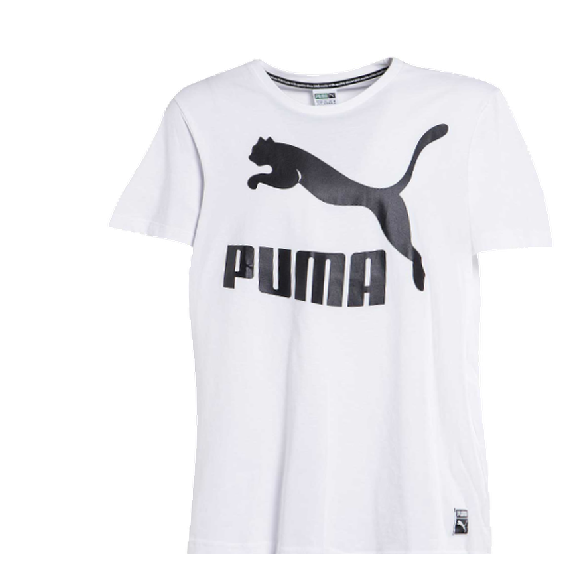

KeyboardInterrupt: ignored

In [59]:
brand = "puma"

!rm -r content/generated/

!rm -r content/$brand
!mkdir content/$brand
!rm content/annotation.txt

!touch content/annotation.txt
!mkdir content/generated

generated_tops_per_background = 20

with open("content/"+brand+".txt") as brand_f:
    for top_id, brand_url in enumerate(brand_f.readlines()):
        with open("content/backgrounds.txt") as backgrounds_f:
            for background_id, background_url in enumerate(backgrounds_f.readlines()):
                for i in range(0, generated_tops_per_background):
                    for br in range(5,17,3):
                        for sat in range(5,17,3):
                            for rot in range(0,31,15):

                                augment(background_url, brand_url, str(top_id),
                                        str(background_id), str(i)+"_"+str(rot), 50, sat, br, 0.0, brand, int(rot))

                                with open('content/annotation.txt', 'r') as f:
                                    lines = f.read().splitlines()
                                    last_line = lines[-1]
                                    if len(last_line.split(",")) > 1:
                                        x1 = last_line.split(",")[-4]
                                        y1 = last_line.split(",")[-3]
                                        x2 = last_line.split(",")[-2]
                                        y2 = last_line.split(",")[-1]

                                if len(last_line.split(",")) > 1:
                                    #print("content/"+str(brand)+"/top_"+str(top_id)+"_background_"+str(background_id)+"_version_"+str(i)+"_"+str(rot)+".png")
                                    im = mpimg.imread("content/"+str(brand)+"/top_"+str(top_id)+"_background_"+str(background_id)+"_version_"+str(i)+"_"+str(rot)+".png")
                                    cv2.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 4)
                                else:
                                    im = mpimg.imread("content/"+last_line.rstrip("\n"))

                                clear_output()
                                plt.figure(figsize=(10,10))
                                imgplot = plt.imshow(im)
                                plt.axis('off')
                                plt.show()

                                time.sleep(1)



#Store generated files (if on Colab)

In [0]:
!zip -r puma.zip puma/

In [0]:
!cp /content/puma.zip /content/drive/Shared\ drives/Get\ That\ Look\ \(GTL\)/Development/TPS_Simple/puma.zip
!cp /content/annotation.txt /content/drive/Shared\ drives/Get\ That\ Look\ \(GTL\)/Development/TPS_Simple/puma.txt

#Make gif

In [0]:
!cd generated && ffmpeg -pattern_type glob -f image2 -r 1 -i "*.png" output.gif

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena